# Importing libraries

In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier


from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import classification_report, fbeta_score, confusion_matrix, precision_recall_curve, auc, make_scorer

# Reading data

In [3]:
accepted_loans = pd.read_csv('../input/mldataset/elite.csv')

In [4]:
accepted_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343380 entries, 0 to 1343379
Data columns (total 79 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1343380 non-null  float64
 1   term                                 1343380 non-null  int64  
 2   int_rate                             1343380 non-null  float64
 3   installment                          1343380 non-null  float64
 4   annual_inc                           1343380 non-null  float64
 5   dti                                  1343380 non-null  float64
 6   delinq_2yrs                          1343380 non-null  float64
 7   fico_range_low                       1343380 non-null  float64
 8   fico_range_high                      1343380 non-null  float64
 9   inq_last_6mths                       1343380 non-null  float64
 10  open_acc                             1343380 non-null  float64
 11

In [5]:
accepted_loans.head()

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,3600.0,60,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,...,0,0,0,1,0,1,0,0,0,0
1,24700.0,60,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,...,1,0,0,1,0,1,0,0,0,0
2,20000.0,60,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,...,0,0,0,1,1,1,0,0,0,0
3,10400.0,60,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,...,0,0,0,1,0,1,0,0,0,0
4,11950.0,60,13.44,405.18,34000.0,10.20,0.0,690.0,694.0,0.0,...,0,0,0,1,0,0,0,0,0,1


In [6]:
accepted_loans.shape

(1343380, 79)

<AxesSubplot:xlabel='loan_paid', ylabel='count'>

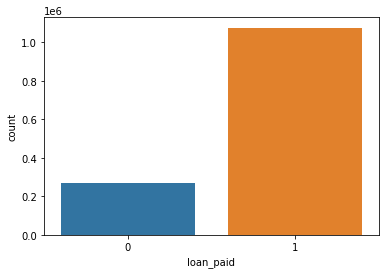

In [7]:
sns.countplot(x=accepted_loans['loan_paid'], data=accepted_loans)

In [8]:
num_fully_paid_loans = accepted_loans[accepted_loans['loan_paid'] == 1.0].shape[0]
num_charged_off_loans = accepted_loans[accepted_loans['loan_paid'] == 0.0].shape[0]
print("The number of Fully Paid loans: ", num_fully_paid_loans)
print("The number of Default loans: ", num_charged_off_loans)
print("Fully Paid / Default Ratio: ", num_fully_paid_loans / num_charged_off_loans)

The number of Fully Paid loans:  1075191
The number of Default loans:  268189
Fully Paid / Default Ratio:  4.009079417873216


# Data Processing

## Preparing parameters

### Features and Labels

In [9]:
X = accepted_loans.loc[:, accepted_loans.columns != 'loan_paid'].values
y = accepted_loans['loan_paid'].values

### Train-Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1074704, 78) (1074704,)
(268676, 78) (268676,)


### Param grid for searching

In [12]:
param_grid = {}

In [13]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

## Outliers handling

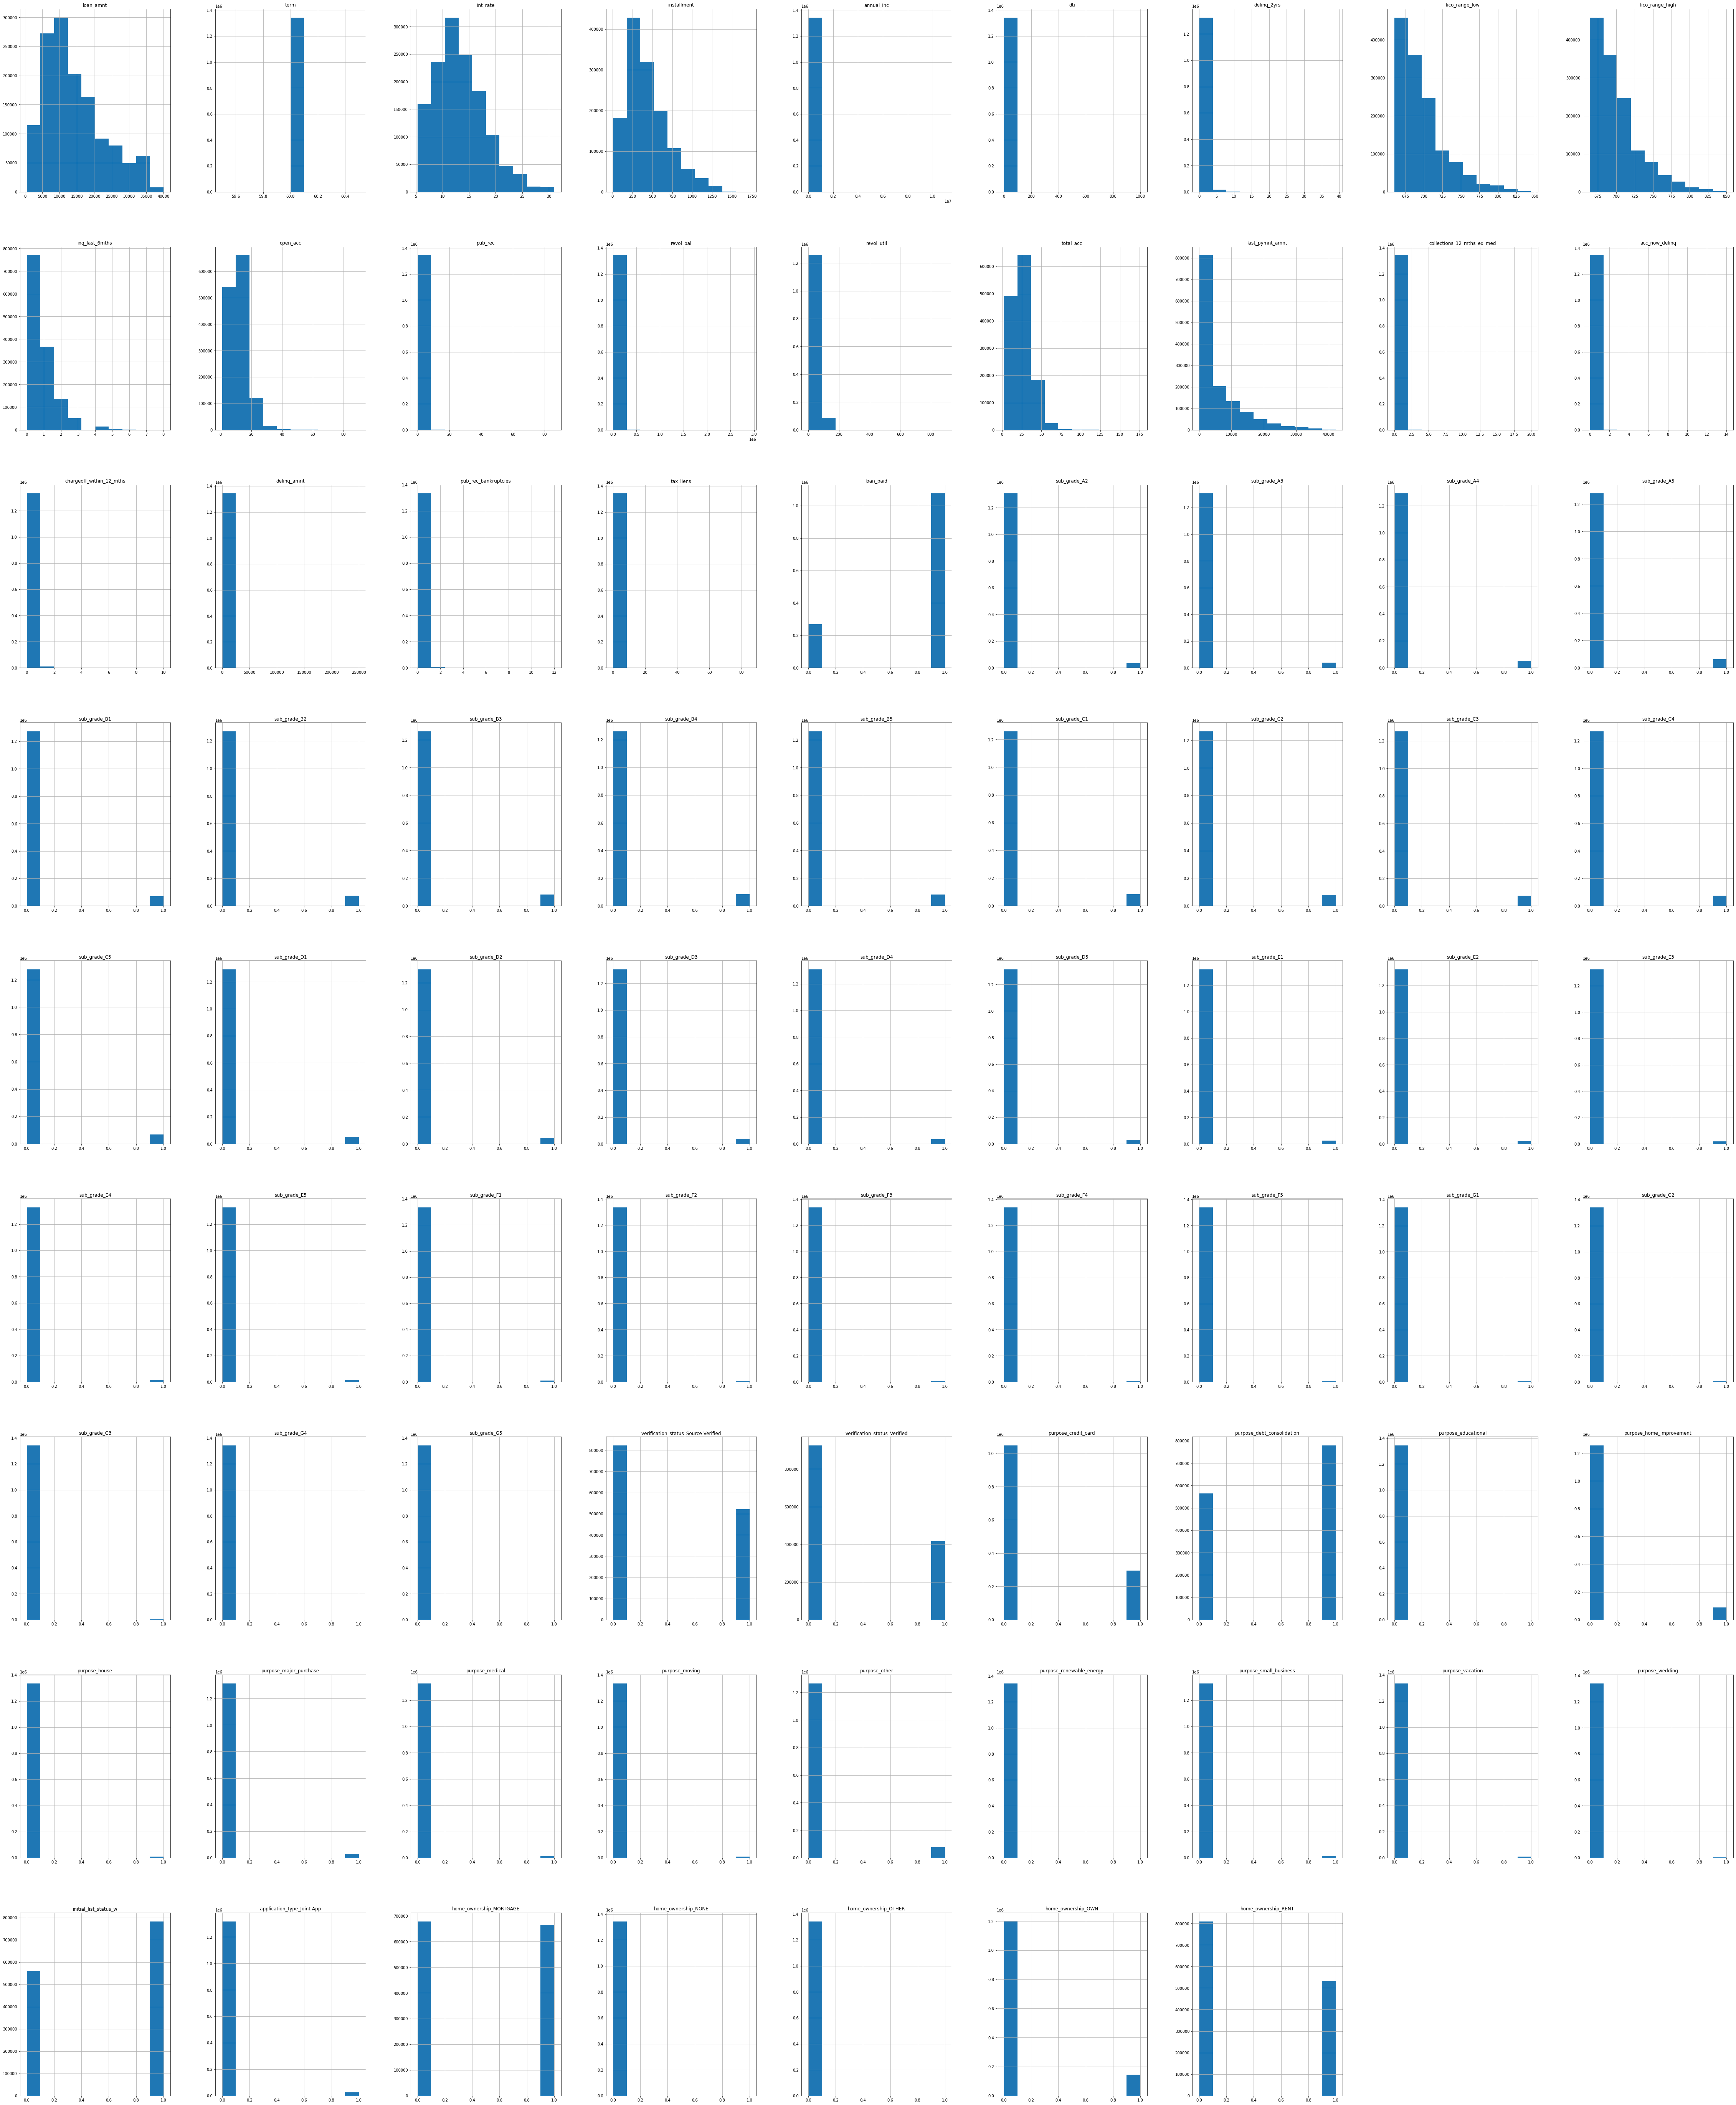

In [14]:
accepted_loans.hist(figsize=(80, 100))
plt.show()

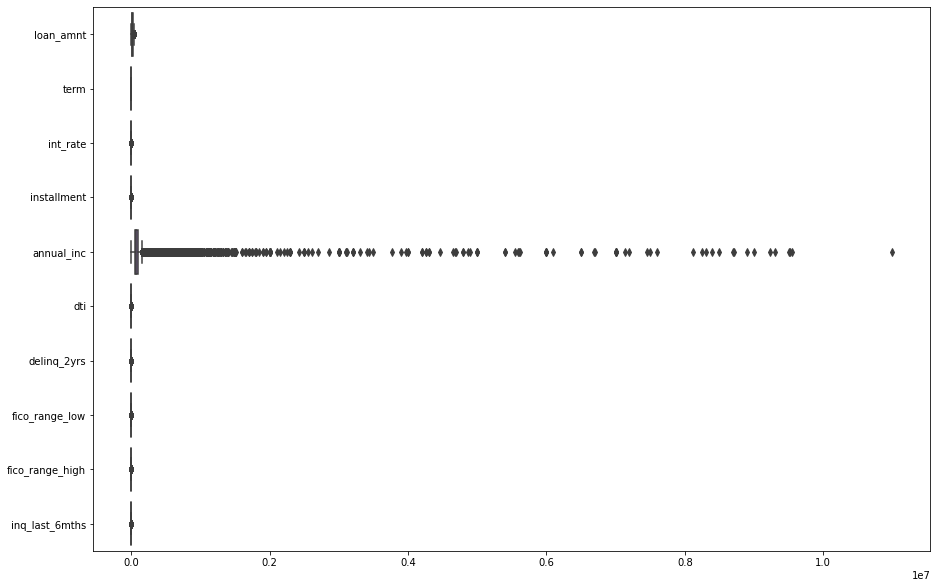

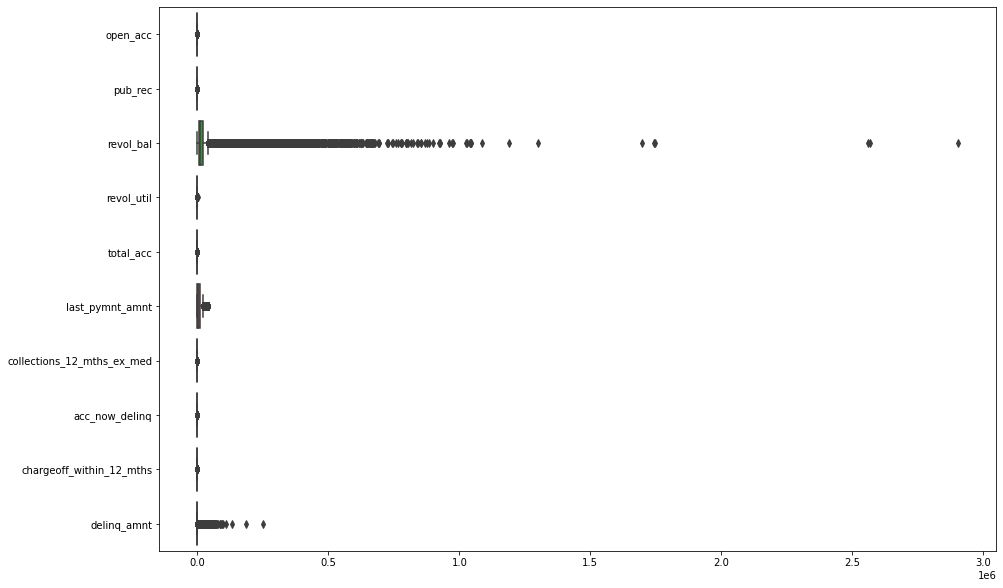

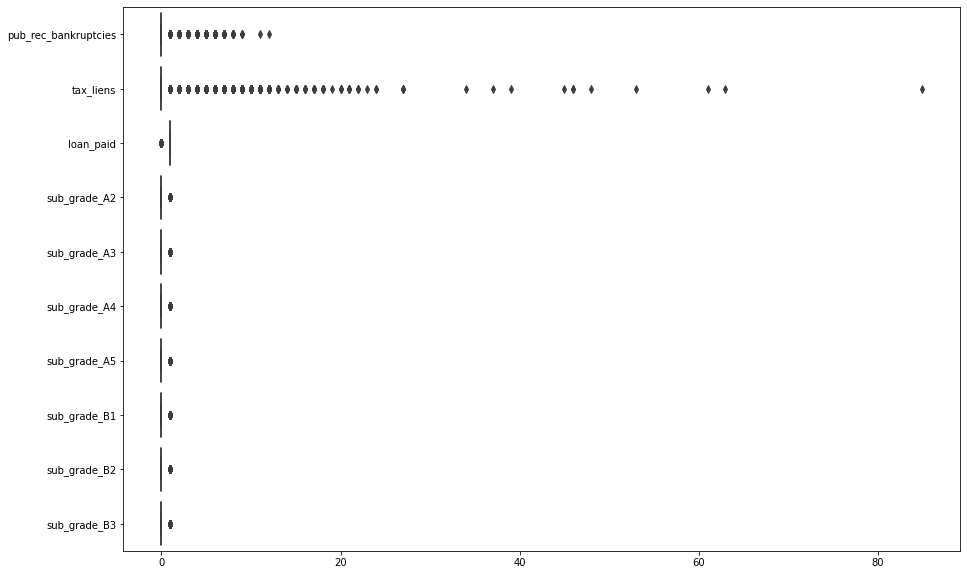

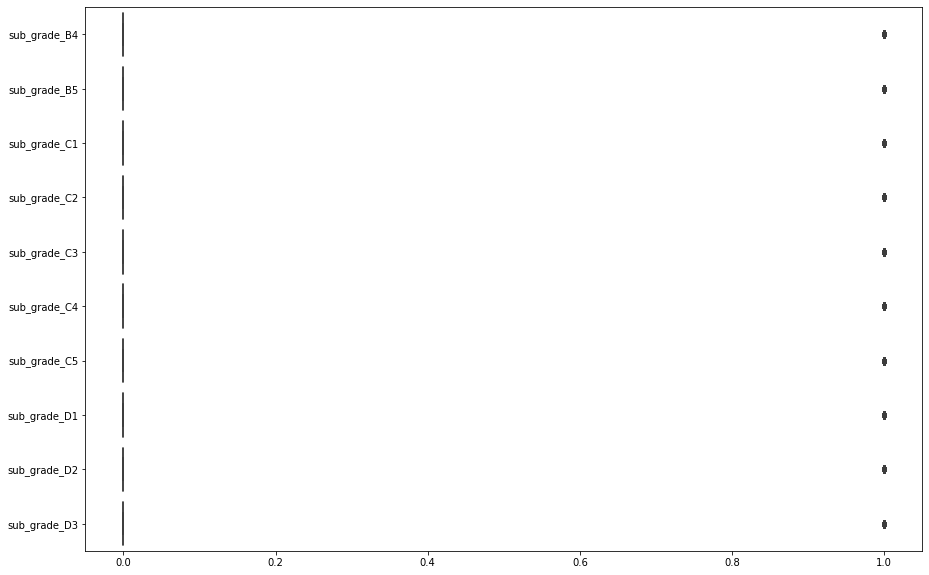

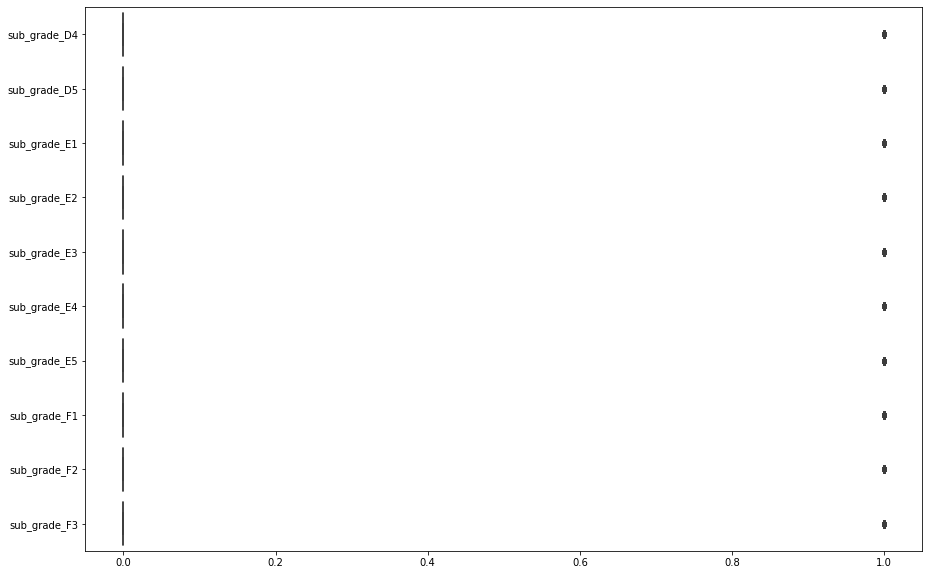

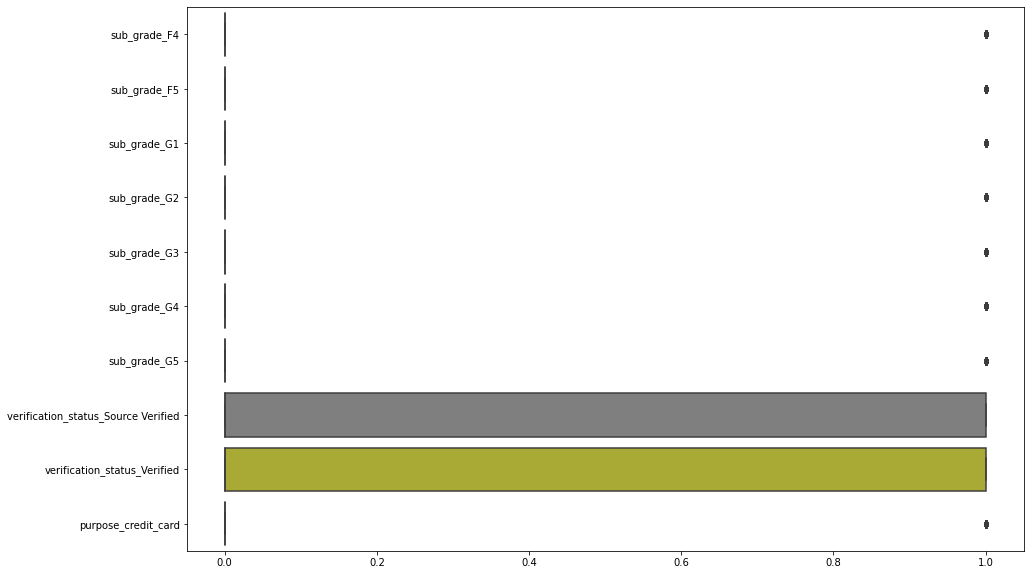

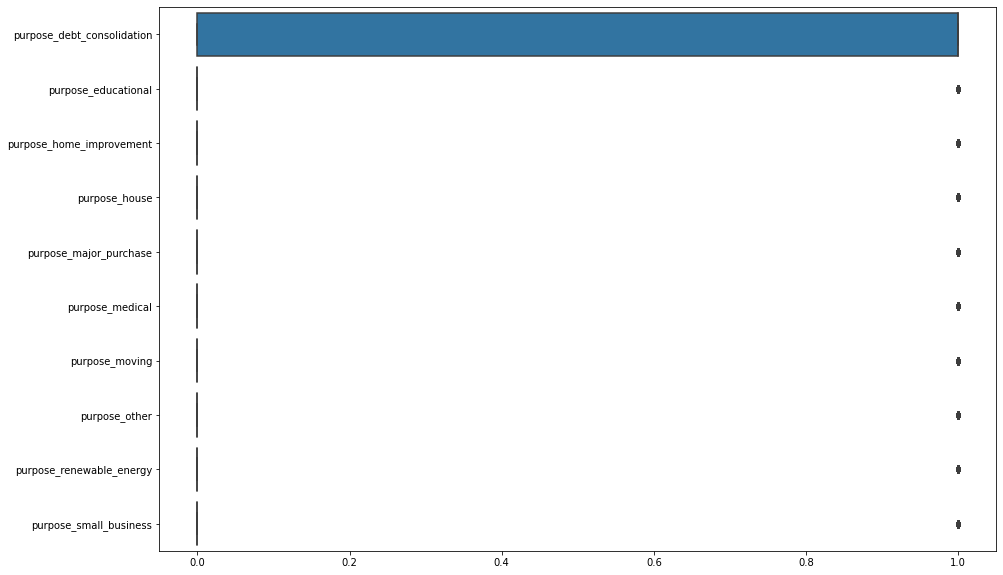

In [15]:
for i in range(0, 70, 10):
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=accepted_loans.iloc[:, i: i + 10], orient='h')
    plt.show()

### Outliers Detection

### Outliers Treating

## Scaler

From plotting the histogram of each input variable, we see that almost variables are located in just 2 bins while others have skewed distribution -> It's better to use MinMaxScaler

In [16]:
minmax_scaler = ('minmax', MinMaxScaler())

## Imbalanced data handling

### SMOTE

In [17]:
smote = ('smote', SMOTE(sampling_strategy=1.0, random_state=42))
smote_param_grid = {
    'smote__sampling_strategy': [0.8, 0.9, 1.0]
    #'smote__k_neighbors': [3, 5, 10, 15]
}

### BorderlineSMOTE

In [18]:
borderline_smote = ('borderline_smote', BorderlineSMOTE(sampling_strategy=1.0, random_state=42))
borderline_smote_param_grid = {
    'borderline_smote__sampling_strategy': np.arange(0.8, 1.01, 0.05),
    'borderline_smote__k_neighbors': [3, 5, 8, 10, 12],
    'borderline_smote__m_neighbors': [5, 10, 12, 15, 18],
}

### SVMSMOTE

In [19]:
svm_smote = ('svm_smote', SVMSMOTE(sampling_strategy=1.0, random_state=42))
svm_smote_param_grid = {
    'svm_smote__sampling_strategy': np.arange(0.8, 1.01, 0.05),
    'svm_smote__k_neighbors': [3, 5, 8, 10, 12],
    'svm_smote__m_neighbors': [5, 10, 12, 15, 18]
}

### ADASYN

In [20]:
adasyn = ('adasyn', ADASYN(sampling_strategy=1.0, random_state=42))
adasyn_param_grid = {
    'adasyn__sampling_strategy': np.arange(0.8, 1.01, 0.05),
    'adasyn__n_neighbors': [3, 5, 8, 10, 12]
}

# Modeling

## Classical models

### Perceptron

In [21]:
perceptron = ('perceptron', Perceptron())
perception_param_grid = {
    
}

### Logistic Regression

In [22]:
lr = ('lr', LogisticRegression())
lr_param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2'],
    'lr__max_iter': [100, 500, 1000],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

### KNN

### SVM

### Decision Tree

In [23]:
dt = ('dt',DecisionTreeClassifier())
dt_param_grid = {
    
}

## Ensemble models

### Random Forest

### XGBoost

### AdaBoost

In [24]:
ada = ('ada', AdaBoostClassifier())
ada_param_grid = {
    'ada__n_estimators':[500,1000,2000],'ada__learning_rate':[.001,0.01,.1]

}

## Deep learning models

### MLP

### ANN

# Training and Evaluation

In [25]:
# Metric
f_onehalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [26]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=cv,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(15, 15))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring=f_onehalf_scorer,
        return_times=True,
        random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times") 
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [27]:
def pooled_var(stds):
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

def plot_search_results(search):
  df = pd.DataFrame(search.cv_results_)
  results = ['mean_test_score',
            'mean_train_score',
            'std_test_score', 
            'std_train_score']

  fig, axes = plt.subplots(1, len(param_grid), 
                          figsize = (7*len(param_grid), 5),
                          sharey='row')
  axes[0].set_ylabel("Score", fontsize=25)


  for idx, (param_name, param_range) in enumerate(param_grid.items()):
      grouped_df = df.groupby(f'param_{param_name}')[results]\
          .agg({'mean_train_score': 'mean',
                'mean_test_score': 'mean',
                'std_train_score': 'mean',
                'std_test_score': 'mean'})

      previous_group = df.groupby(f'param_{param_name}')[results]
      axes[idx].set_xlabel(param_name, fontsize=30)
      axes[idx].set_ylim(0.0, 1.1)
      lw = 2
      axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                  color="darkorange", lw=lw)
      axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                      grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                      color="darkorange", lw=lw)
      axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                  color="navy", lw=lw)
      axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                      grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                      color="navy", lw=lw)

  handles, labels = axes[0].get_legend_handles_labels()
  fig.suptitle('Validation curves', fontsize=40)
  fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

  fig.subplots_adjust(bottom=0.25, top=0.85)  
  plt.show()

In [28]:
def print_result_df(search):
  keeping_columns = ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time']
  df = pd.DataFrame(search.cv_results_)
  df = df[keeping_columns].sort_values(by='mean_test_score', ascending=False)
  return df

In [29]:
def print_best_model_result(search, name):
  print("Best parameter (CV score=):" % search.best_score_)
  best_model = search.best_estimator_
  print(best_model)

  y_pred = best_model.predict(X_test)
  y_score = best_model.predict_proba(X_test)[:, 1]

  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

  # calculate precision and recall for each threshold
  precision, recall, threshold = precision_recall_curve(y_test, y_score)
  # calculate scores
  f_onehalf_score, pr_auc = fbeta_score(y_test, y_pred, beta=0.5), auc(recall, precision)
  print('f0.5_score=', f_onehalf_score)
  print('pr_auc_score=', pr_auc)

  # calculate the no skill line as the proportion of the positive class
  no_skill = len(y_test[y_test==1]) / len(y_test)
  # plot the no skill precision-recall curve
  plt.figure(figsize=(10, 7))
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
  # plot the model precision-recall curve
  plt.plot(recall, precision, marker='.', label=name)
  plt.title(f'{name}(pr_auc={pr_auc})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the legend
  plt.legend()
  # show the plot
  plt.show()

  plot_learning_curve(best_model, name, X_train, y_train, cv=cv, n_jobs=-1 )
  plt.show()

  return best_model, f_onehalf_score, pr_auc

## AdaBoost 

### Base model

In [30]:
pipe = Pipeline(steps=[ada])

In [31]:
param_grid = {}

In [32]:
# HalvingGridSearch 
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [33]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=0.917, test=0.917) total time= 3.1min
[CV 2/10] END .............., score=(train=0.918, test=0.917) total time= 2.3min
[CV 3/10] END .............., score=(train=0.918, test=0.919) total time= 2.2min
[CV 4/10] END .............., score=(train=0.917, test=0.916) total time= 2.2min
[CV 5/10] END .............., score=(train=0.917, test=0.916) total time= 2.2min
[CV 6/10] END .............., score=(train=0.918, test=0.918) total time= 2.2min
[CV 7/10] END .............., score=(train=0.918, test=0.919) total time= 2.2min
[CV 8/10] END .............., score=(train=0.918, test=0.917) total time= 2.2min
[CV 9/10] END .............., score=(train=0.918, test=0.917) total time= 2.2min


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('ada', AdaBoostClassifier())]),
                    param_grid={}, scoring=make_scorer(fbeta_score, beta=0.5),
                    verbose=3)

In [34]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,{},0.917582,0.000472,0.917464,0.000908,134.889598,15.301384


Best parameter (CV score=):
Pipeline(steps=[('ada', AdaBoostClassifier())])
              precision    recall  f1-score   support

           0       0.71      0.64      0.67     53638
           1       0.91      0.93      0.92    215038

    accuracy                           0.88    268676
   macro avg       0.81      0.79      0.80    268676
weighted avg       0.87      0.88      0.87    268676

[[ 34556  19082]
 [ 14285 200753]]
f0.5_score= 0.9172013691795705
pr_auc_score= 0.9838489504508725


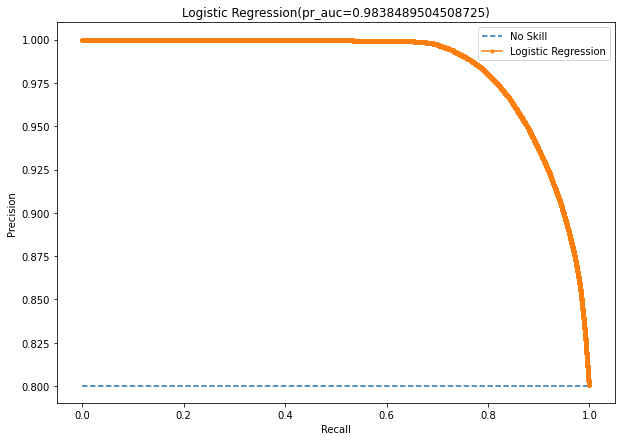

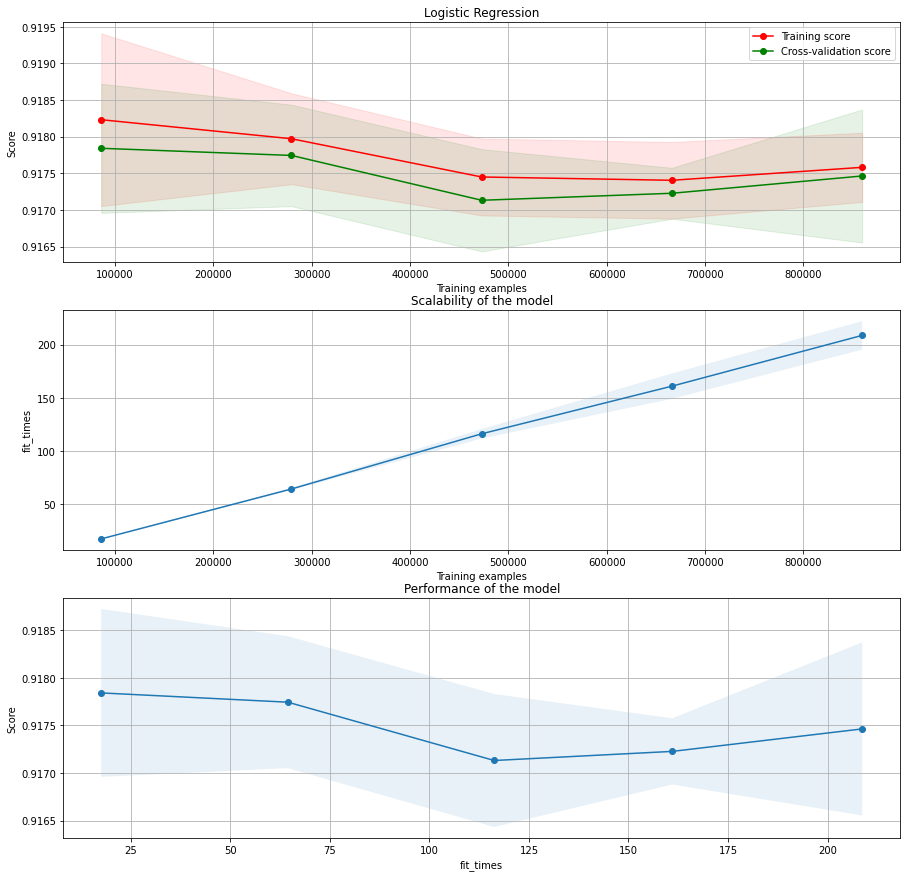

(Pipeline(steps=[('ada', AdaBoostClassifier())]),
 0.9172013691795705,
 0.9838489504508725)

In [35]:
print_best_model_result(search, 'Logistic Regression')

### MinMaxScaler + adaBoost 

In [36]:
pipe = Pipeline(steps=[minmax_scaler, ada])

In [37]:
param_grid = {}

In [38]:
# HalvingGridSearch 
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=3, return_train_score=True)

In [39]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=0.917, test=0.917) total time= 2.2min
[CV 2/10] END .............., score=(train=0.918, test=0.917) total time= 2.2min
[CV 3/10] END .............., score=(train=0.918, test=0.919) total time= 2.2min
[CV 4/10] END .............., score=(train=0.917, test=0.916) total time= 2.2min
[CV 5/10] END .............., score=(train=0.917, test=0.916) total time= 2.2min
[CV 6/10] END .............., score=(train=0.918, test=0.918) total time= 2.3min
[CV 7/10] END .............., score=(train=0.918, test=0.919) total time= 2.3min
[CV 8/10] END .............., score=(train=0.918, test=0.917) total time= 2.3min
[CV 9/10] END .............., score=(train=0.918, test=0.917) total time= 2.2min


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                              ('ada', AdaBoostClassifier())]),
                    param_grid={}, scoring=make_scorer(fbeta_score, beta=0.5),
                    verbose=3)

In [40]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,{},0.917582,0.000472,0.917464,0.000908,130.638592,1.517421


Best parameter (CV score=):
Pipeline(steps=[('minmax', MinMaxScaler()), ('ada', AdaBoostClassifier())])
              precision    recall  f1-score   support

           0       0.71      0.64      0.67     53638
           1       0.91      0.93      0.92    215038

    accuracy                           0.88    268676
   macro avg       0.81      0.79      0.80    268676
weighted avg       0.87      0.88      0.87    268676

[[ 34556  19082]
 [ 14284 200754]]
f0.5_score= 0.9172025855688416
pr_auc_score= 0.9838494149231076


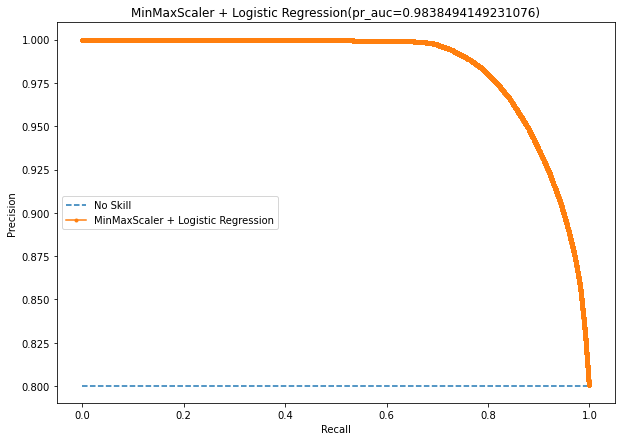

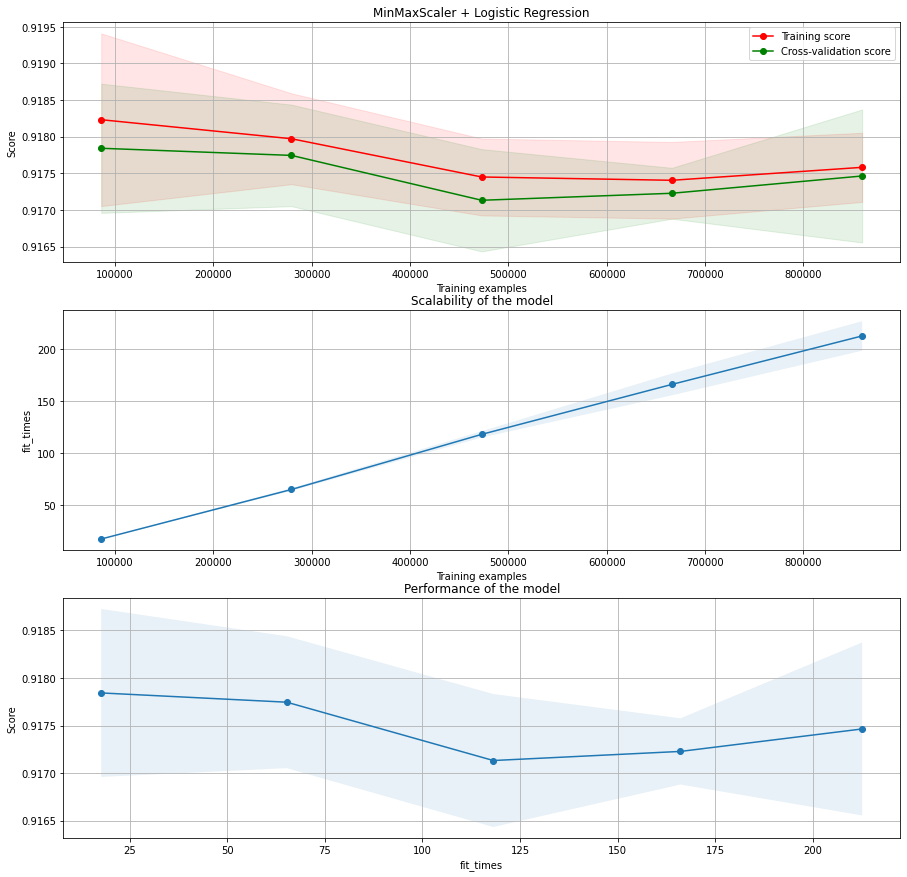

(Pipeline(steps=[('minmax', MinMaxScaler()), ('ada', AdaBoostClassifier())]),
 0.9172025855688416,
 0.9838494149231076)

In [41]:
print_best_model_result(search, 'MinMaxScaler + Logistic Regression')

### MinMaxScale + SMOTE + AdaBoost

In [42]:
pipe = Pipeline(steps=[minmax_scaler, smote, ada])

In [43]:
param_grid = {}

In [44]:
search = HalvingGridSearchCV(pipe, param_grid, scoring=f_onehalf_scorer, cv=cv, verbose=4, return_train_score=True)

In [45]:
search.fit(X_train, y_train)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1074704
max_resources_: 1074704
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1074704
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .............., score=(train=0.933, test=0.934) total time=15.7min
[CV 2/10] END .............., score=(train=0.932, test=0.931) total time=16.0min
[CV 3/10] END .............., score=(train=0.935, test=0.934) total time=15.9min
[CV 4/10] END .............., score=(train=0.933, test=0.932) total time=15.1min
[CV 5/10] END .............., score=(train=0.932, test=0.932) total time=16.3min
[CV 6/10] END .............., score=(train=0.932, test=0.932) total time=14.8min
[CV 7/10] END .............., score=(train=0.933, test=0.933) total time=16.3min
[CV 8/10] END .............., score=(train=0.932, test=0.932) total time=15.4min
[CV 9/10] END .............., score=(train=0.933, test=0.933) total time=16.2min


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42),
                    estimator=Pipeline(steps=[('minmax', MinMaxScaler()),
                                              ('smote',
                                               SMOTE(random_state=42,
                                                     sampling_strategy=1.0)),
                                              ('ada', AdaBoostClassifier())]),
                    param_grid={}, scoring=make_scorer(fbeta_score, beta=0.5),
                    verbose=4)

In [46]:
print_result_df(search)

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time
0,{},0.932709,0.000752,0.932554,0.001039,943.144256,29.594005


Best parameter (CV score=):
Pipeline(steps=[('minmax', MinMaxScaler()),
                ('smote', SMOTE(random_state=42, sampling_strategy=1.0)),
                ('ada', AdaBoostClassifier())])
              precision    recall  f1-score   support

           0       0.56      0.88      0.68     53638
           1       0.96      0.83      0.89    215038

    accuracy                           0.84    268676
   macro avg       0.76      0.85      0.79    268676
weighted avg       0.88      0.84      0.85    268676

[[ 47130   6508]
 [ 36867 178171]]
f0.5_score= 0.9340511284880587
pr_auc_score= 0.9819757620063108


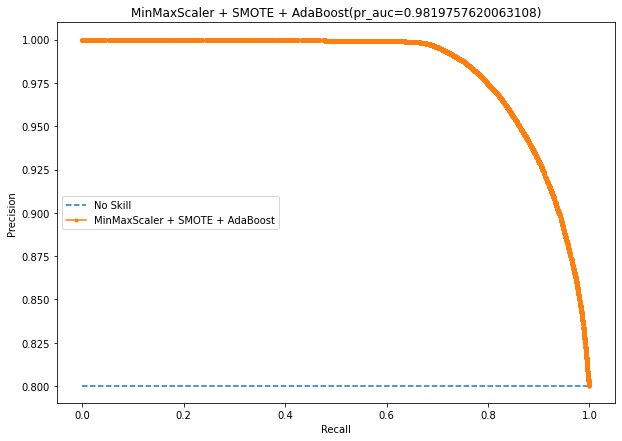

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

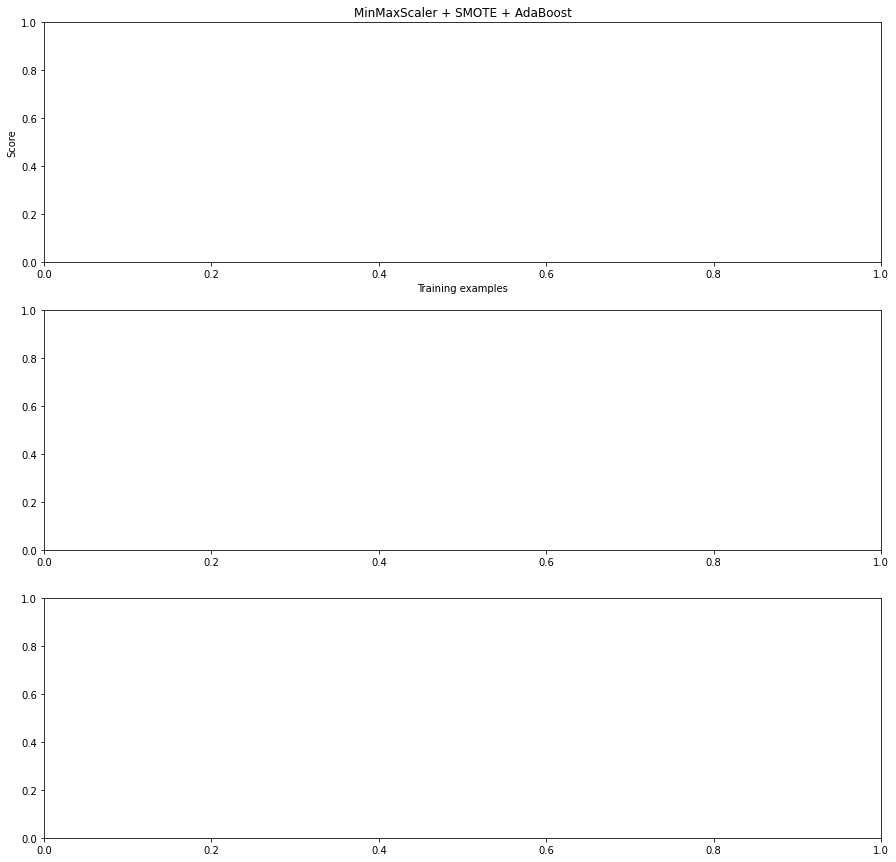

In [47]:
print_best_model_result(search, 'MinMaxScaler + SMOTE + AdaBoost')